# Bank Marketing Prediction Study

We will use a marketing/banking dataset obtained from the UCI Machine Learning repository - https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

The dataset is related to phone call marketing campaigns of Portugese banking institutions.

The goal is to find the most accurate model that predicts whether the client will subsribe to a term deposit or not.

The target variable, y is a yes/no.

We will use sklearn for
 - pre-processing,
 - splitting data for train/test
 - comparing 4 models (DummyClassifier, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier)
 - comparing metrics (confusion matrix, accuracy, recall, f1, precision, auc)

In [79]:
from IPython import get_ipython

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    auc,
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
get_ipython().run_line_magic("matplotlib", "inline")

## Data Collection

**The attribute information from UCI**<br>

**Input variables:**<br>
 - **bank client data:**<br>
 1 - age (numeric)<br>
 2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')<br>
 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)<br>
 4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')<br>
 5 - default: has credit in default? (categorical: 'no','yes','unknown')<br>
 6 - housing: has housing loan? (categorical: 'no','yes','unknown')<br>
 7 - loan: has personal loan? (categorical: 'no','yes','unknown')<br>
 - **related with the last contact of the current campaign:**<br>
 8 - contact: contact communication type (categorical: 'cellular','telephone')<br>
 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br>
 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')<br>
 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.<br>
 - **other attributes:**<br>
 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)<br>
 14 - previous: number of contacts performed before this campaign and for this client (numeric)<br>
 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')<br>
 - **social and economic context attributes:**<br>
 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)<br>
 17 - cons.price.idx: consumer price index - monthly indicator (numeric)<br>
 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)<br>
 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)<br>
 20 - nr.employed: number of employees - quarterly indicator (numeric)<br>

 **Output variable (desired target):**<br>
 21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

**Generate a Pandas dataframe from the .csv file.**<br>
It uses a semicolon delimiter.

In [6]:
bank_df = pd.read_csv("bank-additional-full.csv", delimiter=";")

## Preliminary Data Exploration

In [7]:
bank_df.shape

(41188, 21)

Glance at some initial stats and descriptions

In [8]:
bank_df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


**Number of unique values in each column**

In [9]:
for c in bank_df.columns:
    print(c, bank_df[c].nunique())

age 78
job 12
marital 4
education 8
default 3
housing 3
loan 3
contact 2
month 10
day_of_week 5
duration 1544
campaign 42
pdays 27
previous 8
poutcome 3
emp.var.rate 10
cons.price.idx 26
cons.conf.idx 26
euribor3m 316
nr.employed 11
y 2


Peek at unique values of some questionable columns

In [10]:
for u in ["job", "previous", "emp.var.rate"]:
    print(u + ": ", bank_df[u].unique())

job:  ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
previous:  [0 1 2 3 4 5 6 7]
emp.var.rate:  [ 1.1  1.4 -0.1 -0.2 -1.8 -2.9 -3.4 -3.  -1.7 -1.1]


2 types of contact<br>
 landline or cell

In [11]:
bank_df["contact"].unique()

array(['telephone', 'cellular'], dtype=object)

'default' is yes/no/unknown

In [12]:
bank_df["default"].unique()

array(['no', 'unknown', 'yes'], dtype=object)

'pdays' is the number of days that passed by after the client was last contacted from a previous campaign -
999 means the client has not been contacted

In [13]:
bank_df["pdays"].unique()

array([999,   6,   4,   3,   5,   1,   0,  10,   7,   8,   9,  11,   2,
        12,  13,  14,  15,  16,  21,  17,  18,  22,  25,  26,  19,  27,
        20])

There don't appear to be any null values.

In [14]:
bank_df.isnull().sum(axis=0)

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

12 duplicated values

In [15]:
bank_df.duplicated().sum()

np.int64(12)

In [16]:
# view the duplicates
bank_df[bank_df.duplicated()]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
20216,55,services,married,high.school,unknown,no,no,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
20534,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
25217,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
28477,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
32516,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no


**Drop the duplicates since there are only 12 out of the 41k**

In [17]:
bank_df.drop_duplicates(inplace=True)

Turn the 3 'basic' education types into one.

In [18]:
bank_df.replace(["basic.6y", "basic.4y", "basic.9y"], "basic", inplace=True)

Create a 'contacted' column from pdays to a 0/1 (no/yes)

In [19]:
bank_df["contacted"] = [0 if x == 999 else 1 for x in bank_df["pdays"]]

Create numeric columns out of 'y', 'day_of_week', and 'month'.

In [20]:
bank_df["y_num"] = bank_df[["y"]].replace({"no": 0, "yes": 1})
bank_df["dow_num"] = bank_df[["day_of_week"]].replace(
    {"mon": 0, "tue": 1, "wed": 2, "thu": 3, "fri": 4}
)
bank_df["month_num"] = bank_df[["month"]].replace(
    {
        "mar": 3,
        "apr": 4,
        "may": 5,
        "jun": 6,
        "jul": 7,
        "aug": 8,
        "sep": 9,
        "oct": 10,
        "nov": 11,
        "dec": 12,
    }
)

/var/folders/5j/7pkcmnsj6l5194373nzfr0h40000gn/T/ipykernel_8929/3478686022.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bank_df["y_num"] = bank_df[["y"]].replace({"no": 0, "yes": 1})
/var/folders/5j/7pkcmnsj6l5194373nzfr0h40000gn/T/ipykernel_8929/3478686022.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bank_df["dow_num"] = bank_df[["day_of_week"]].replace(
/var/folders/5j/7pkcmnsj6l5194373nzfr0h40000gn/T/ipykernel_8929/3478686022.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed 

Drop the original ones

In [21]:
bank_df.drop(["y", "day_of_week", "month", "pdays"], axis=1, inplace=True)

**The target variable is 'y_num'.**<br>
 Has the client subscribed to a term deposit or not?<br>
 Create a dataframe of the yes (1) records.

In [22]:
yes_df = bank_df[bank_df["y_num"] == 1]

Percentage of clients who have subscribed = 11%<br>
 Imbalanced dataset

In [23]:
((yes_df.shape[0]) / (bank_df.shape[0])) * 100

11.266271614532737

**Descriptive and exploratory analytics**

Clients with university degrees, admin jobs, and non-existent previous campaign have the highest proportion of clients subscribing to a term deposit

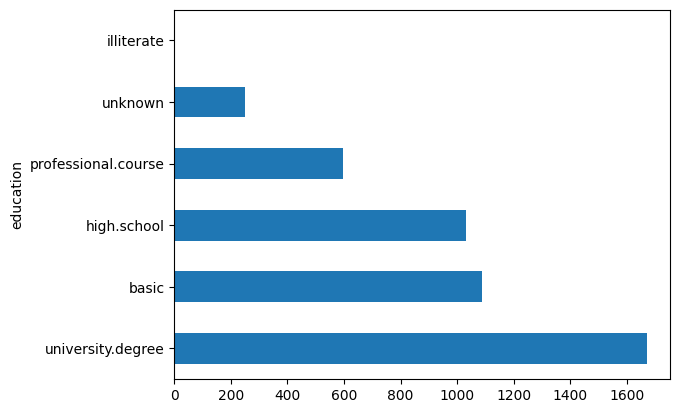

In [24]:
# university degree highest
yes_df["education"].value_counts().plot(kind="barh")
plt.show()

Clients with admin jobs

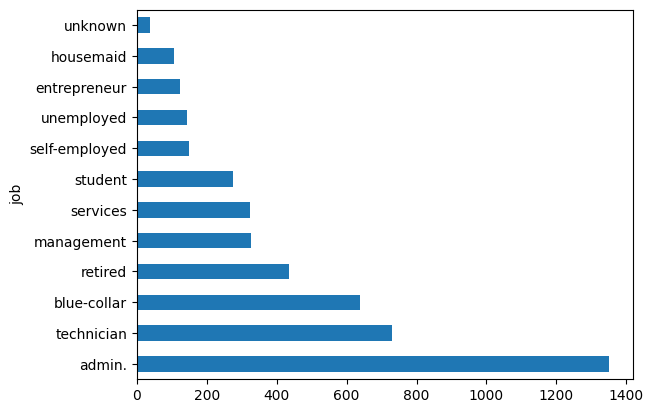

In [25]:
# admin highest
yes_df["job"].value_counts().plot(kind="barh")
plt.show()

Outcome of the previous marketing campaign - Nonexistent is the highest

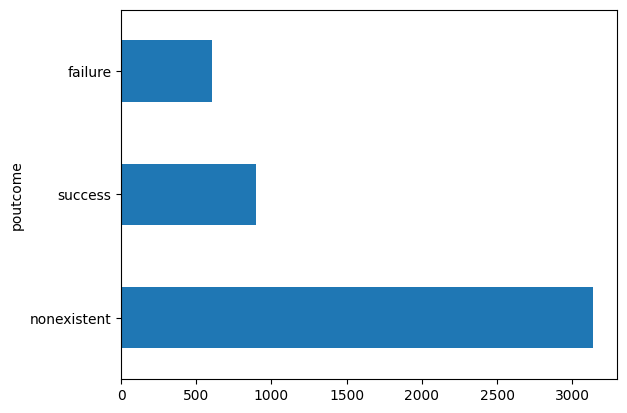

In [26]:
yes_df["poutcome"].value_counts().plot(kind="barh")
plt.show()

**Category columns**

In [27]:
cat_cols = list(bank_df.columns[bank_df.dtypes == object])
cat_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'poutcome']

**Numeric columns**

In [28]:
num_cols = list(bank_df.columns[bank_df.dtypes != object])
num_cols

['age',
 'duration',
 'campaign',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'contacted',
 'y_num',
 'dow_num',
 'month_num']

Look at correlation between variables

Some multicollinearity from looking at the corralation matrix

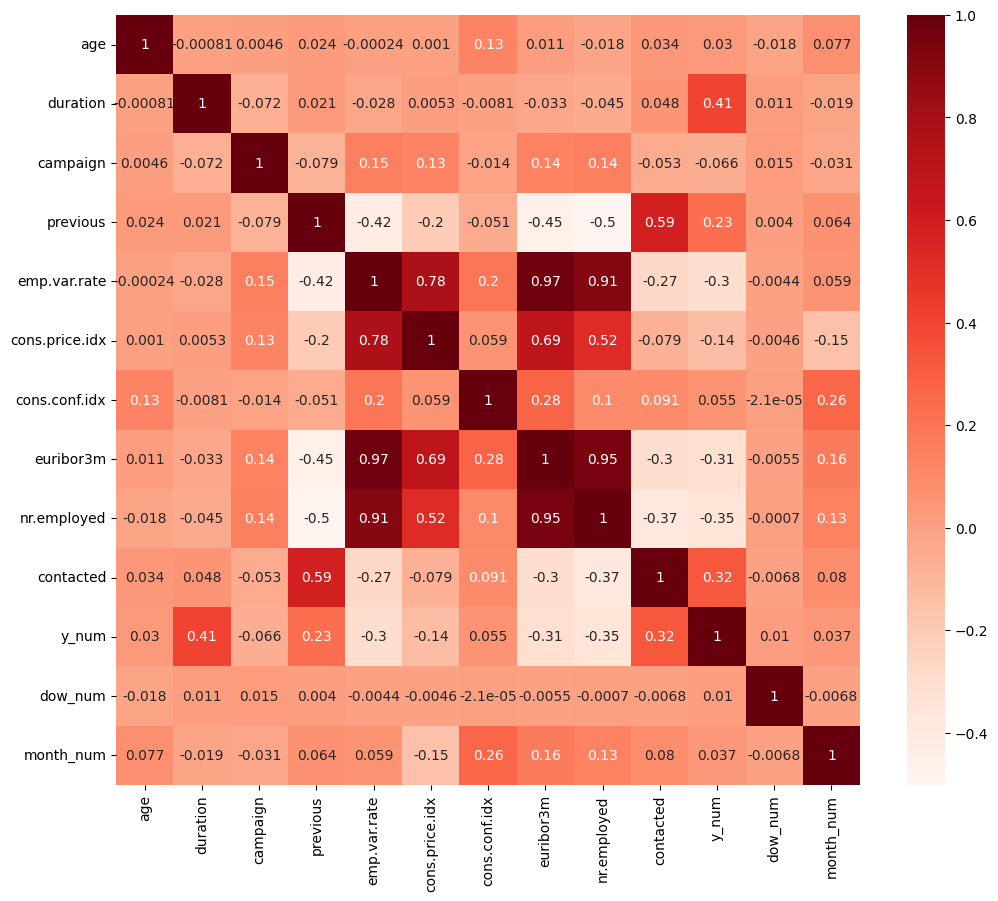

In [ ]:
plt.figure(figsize=(12, 10))
cor = bank_df[num_cols].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

A note from the UCI data source site: The 'duration' attribute highly affects the target variable. It should be removed if we would like to have a realistic model.

'contacted' (whether they were contacted previously or not) seems to have the next highest correlation with 'y_num' (0.32)

In [33]:
bank_df.drop(["duration"], axis=1, inplace=True)

## Data Preparation

**Use LabelEncoder for the categorical columns to get 0/1 values**

In [35]:
le = preprocessing.LabelEncoder()
for c in cat_cols:
    bank_df[c] = le.fit_transform(bank_df[c])

**Independent and dependent variables in to X and y**

In [36]:
X = bank_df.loc[:, bank_df.columns != "y_num"]
y = bank_df.loc[:, "y_num"]

**Split for train and test using 80/20 ratio**

using train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [38]:
print("Dimensions of X_train: ", X_train.shape)
print("Dimensions of X_test: ", X_test.shape)
print("Dimensions of y_train: ", y_train.shape)
print("Dimensions of y_test: ", y_test.shape)

Dimensions of X_train:  (32940, 19)
Dimensions of X_test:  (8236, 19)
Dimensions of y_train:  (32940,)
Dimensions of y_test:  (8236,)


**We will compare with scaled data using sklearn's preprocessing.StandardScaler**<br>
See if accuracy improves

In [39]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

Function to print the accuracy, recall, precision, and F1 scores

In [40]:
def print_scores(pred, type_string):

    accuracy = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred)
    precision = precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    print(type_string + " Scores:")
    print("   Accuracy: ", accuracy)
    print("   Recall: ", recall)
    print("   Precision: ", precision)
    print("   F1 score: ", f1)

Function to plot the False and True Positive rates and show AUC scores

In [41]:
def auc_plot(pred, type_string):

    fpr, tpr, _ = roc_curve(y_test, pred)
    auc_score = auc(fpr, tpr)

    fig = plt.figure(figsize=(8, 5))

    plt.plot(fpr, tpr, label="AUC score is : " + str(auc_score))
    plt.xlabel("F.P.R.", fontsize=10)
    plt.ylabel("T.P.R", fontsize=10)
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend()

    plt.plot([0, 1], [0, 1], "r--")
    plt.show()

    print("AUC Score for " + type_string + " is", roc_auc_score(y_test, pred))

## Compare ML Models

**We will compare the results of scaled and un-scaled data for<br>
Dummy Classifer, Logistic Regression, Decision Tree, and Random Forest**

We will look at confusion matrices of the different predictions

|                   |Predicted Negative|Predicted Postive|
|-------------------|------------------|-----------------|
|**Actual Negative**|True Negative     |False Positive   |
|**Actual Positive**|False Negative    |True Positive    |

### Dummy Classifier

**Fit and predict**

In [42]:
dummy = DummyClassifier()

## fit on the training data
dummy.fit(X_train, y_train)

## make predictions on test data
dummy_test_pred = dummy.predict(X_test)

## fit on the scaled training data
dummy.fit(X_train_scale, y_train)

## make predictions on scaled test data
dummy_test_pred_scale = dummy.predict(X_test_scale)

**Confusion matrix**

In [43]:
dummy_matrix = confusion_matrix(y_test, dummy_test_pred)
print("Dummy, not scaled: " + "\n\n" + str(dummy_matrix) + "\n")

dummy_matrix_scale = confusion_matrix(y_test, dummy_test_pred_scale)
print("Dummy, scaled: " + "\n\n" + str(dummy_matrix_scale))

Dummy, not scaled: 

[[7269    0]
 [ 967    0]]

Dummy, scaled: 

[[7269    0]
 [ 967    0]]


The Overall Error Rate is fairly high here for both scaled and un-scaled

In [44]:
print_scores(dummy_test_pred, "Dummy Classifier")

Dummy Classifier Scores:
   Accuracy:  0.8825886352598349
   Recall:  0.0
   Precision:  0.0
   F1 score:  0.0


/opt/anaconda3/envs/data-science-adventures/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [45]:
print_scores(dummy_test_pred_scale, "Scaled Dummy Classifier")

Scaled Dummy Classifier Scores:
   Accuracy:  0.8825886352598349
   Recall:  0.0
   Precision:  0.0
   F1 score:  0.0


/opt/anaconda3/envs/data-science-adventures/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

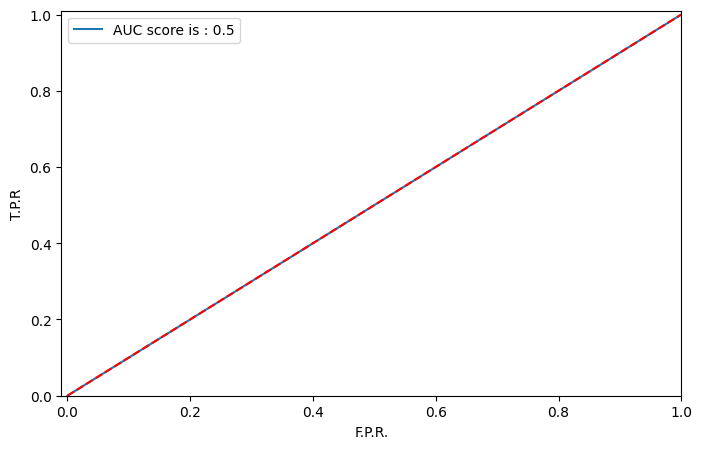

AUC Score for Dummy Classifier is 0.5


In [46]:
auc_plot(dummy_test_pred, "Dummy Classifier")

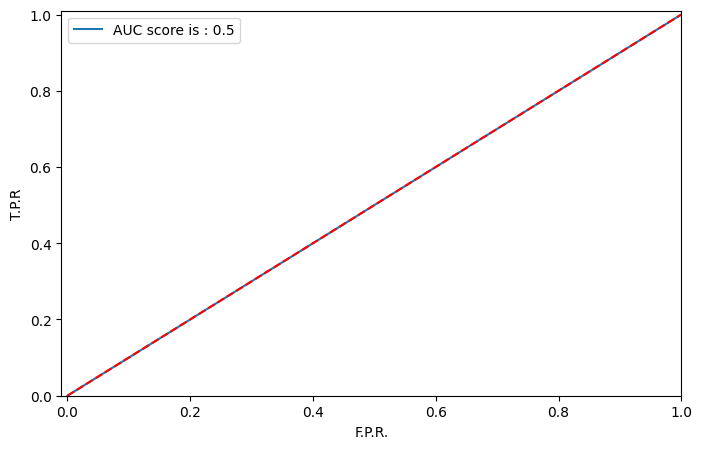

AUC Score for Scaled Dummy Classifier is 0.5


In [47]:
auc_plot(dummy_test_pred_scale, "Scaled Dummy Classifier")

AUC scores are low for Dummy Classifier and scaling did not improve the results

### Logistic Regression

**Fit and predict**

In [48]:
## max_iter = 1000
logr = LogisticRegression(random_state=0, max_iter=1000)
logr.fit(X_train, y_train)
logr_test_pred = logr.predict(X_test)

/opt/anaconda3/envs/data-science-adventures/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
logr.fit(X_train_scale, y_train)
logr_test_pred_scale = logr.predict(X_test_scale)

**Confusion matrix**

In [50]:
logr_matrix = confusion_matrix(y_test, logr_test_pred)
print("LGR, not scaled: " + "\n\n" + str(logr_matrix) + "\n")

LGR, not scaled: 

[[7193   76]
 [ 786  181]]



In [51]:
logr_matrix_scale = confusion_matrix(y_test, logr_test_pred_scale)
print("LGR, scaled: " + "\n\n" + str(logr_matrix_scale) + "\n")

LGR, scaled: 

[[7181   88]
 [ 777  190]]



**Scores**

In [52]:
print_scores(logr_test_pred, "Logistic Regression")

Logistic Regression Scores:
   Accuracy:  0.8953375424963574
   Recall:  0.18717683557394002
   Precision:  0.7042801556420234
   F1 score:  0.2957516339869281


In [53]:
print_scores(logr_test_pred_scale, "Scaled Logistic Regression")

Scaled Logistic Regression Scores:
   Accuracy:  0.8949732880038854
   Recall:  0.19648397104446744
   Precision:  0.6834532374100719
   F1 score:  0.30522088353413657


Accuracy is higher but scores did not improve with scaling

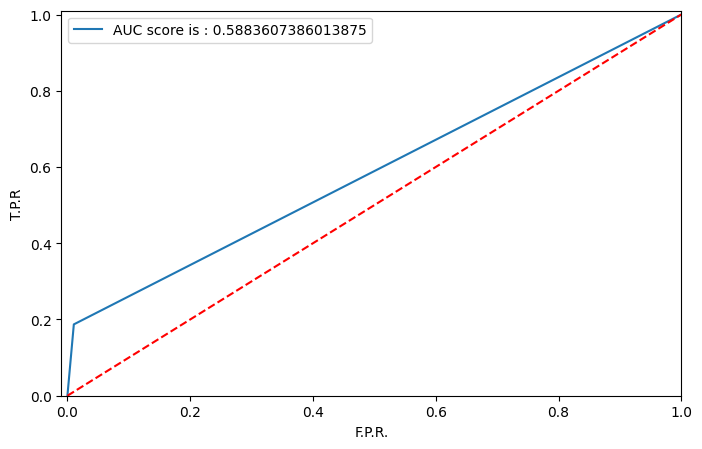

AUC Score for Logistic Regression is 0.5883607386013875


In [54]:
auc_plot(logr_test_pred, "Logistic Regression")

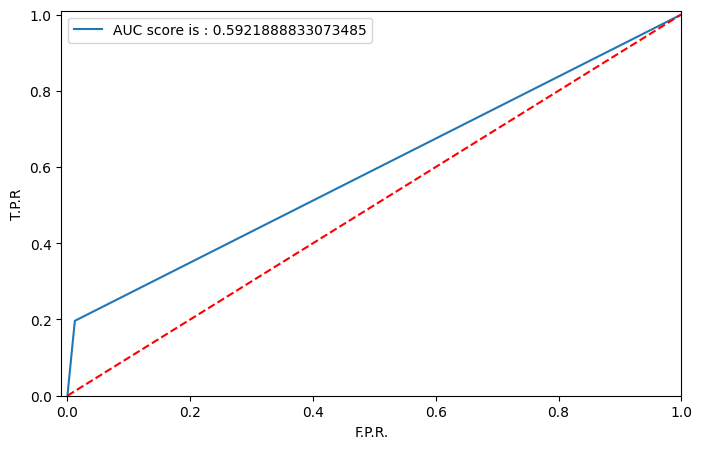

AUC Score for Scaled Logistic Regression is 0.5921888833073485


In [55]:
auc_plot(logr_test_pred_scale, "Scaled Logistic Regression")

Although AUC is slightly higher

### Decision Tree Classifier

**Fit and predict**

In [56]:
## limit the depth to 5
dt = DecisionTreeClassifier(max_depth=5, random_state=15)
dt.fit(X_train, y_train)
dt_test_pred = dt.predict(X_test)

## scale
dt.fit(X_train_scale, y_train)
dt_test_pred_scale = dt.predict(X_test_scale)

**Confusion matrix**

In [57]:
dt_matrix = confusion_matrix(y_test, dt_test_pred)
print("DT, not scaled: " + "\n\n" + str(dt_matrix) + "\n")

DT, not scaled: 

[[7173   96]
 [ 744  223]]



In [58]:
dt_matrix_scale = confusion_matrix(y_test, dt_test_pred_scale)
print("DT, not scaled: " + "\n\n" + str(dt_matrix_scale) + "\n")

DT, not scaled: 

[[7173   96]
 [ 744  223]]



**Scores**

In [59]:
print_scores(dt_test_pred, "Decision Tree")

Decision Tree Scores:
   Accuracy:  0.8980087421078193
   Recall:  0.23061013443640124
   Precision:  0.6990595611285266
   F1 score:  0.3468118195956454


In [60]:
print_scores(dt_test_pred_scale, "Scaled Decision Tree")

Scaled Decision Tree Scores:
   Accuracy:  0.8980087421078193
   Recall:  0.23061013443640124
   Precision:  0.6990595611285266
   F1 score:  0.3468118195956454


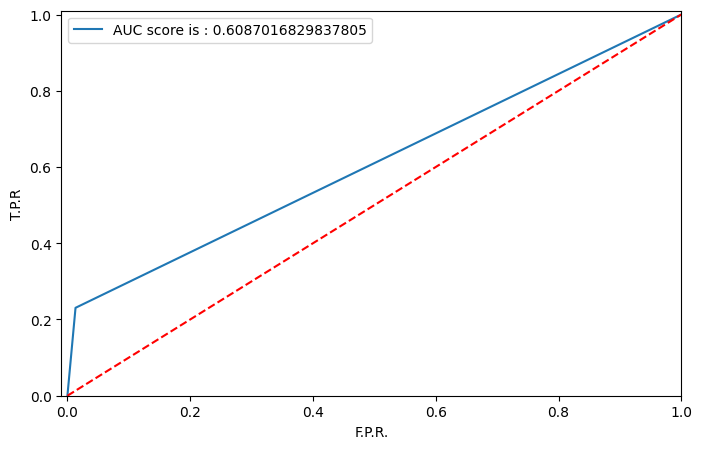

AUC Score for Decision Tree is 0.6087016829837805


In [61]:
auc_plot(dt_test_pred, "Decision Tree")

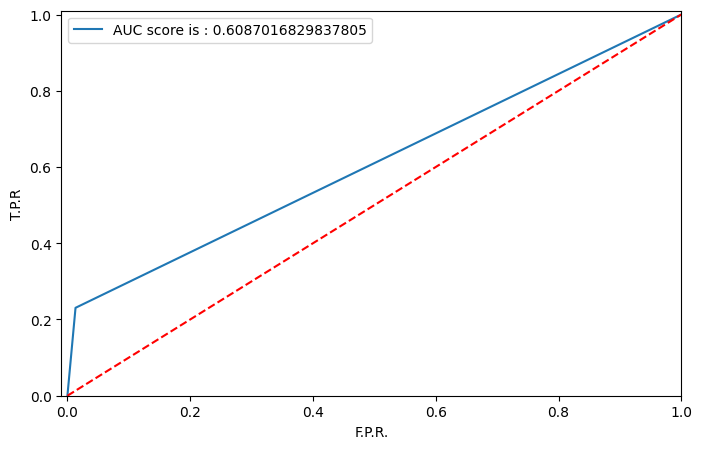

AUC Score for Scaled Decision Tree is 0.6087016829837805


In [62]:
auc_plot(dt_test_pred_scale, "Scaled Decision Tree")

No difference with scaling for Decision Tree classifier

### RandomForest

**Fit and predict**

In [63]:
rfc = RandomForestClassifier()

In [66]:
rfc.fit(X_train, y_train)
rfc_test_pred = rfc.predict(X_test)

## scale
rfc.fit(X_train_scale, y_train)
rfc_test_pred_scale = rfc.predict(X_test_scale)

**Confusion matrix**

In [67]:
rfc_matrix = confusion_matrix(y_test, rfc_test_pred)
print("RF, not scaled: " + "\n\n" + str(rfc_matrix) + "\n")

RF, not scaled: 

[[7086  183]
 [ 709  258]]



In [68]:
rfc_matrix_scale = confusion_matrix(y_test, rfc_test_pred_scale)
print("RF, scaled: " + "\n\n" + str(rfc_matrix_scale) + "\n")

RF, scaled: 

[[7073  196]
 [ 706  261]]



**Scores**

In [69]:
print_scores(rfc_test_pred, "Random Forest")

Random Forest Scores:
   Accuracy:  0.8916949975716367
   Recall:  0.26680455015511895
   Precision:  0.5850340136054422
   F1 score:  0.3664772727272727


In [70]:
print_scores(rfc_test_pred_scale, "Scaled Random Forest")

Scaled Random Forest Scores:
   Accuracy:  0.8904808159300631
   Recall:  0.26990692864529475
   Precision:  0.5711159737417943
   F1 score:  0.36657303370786515


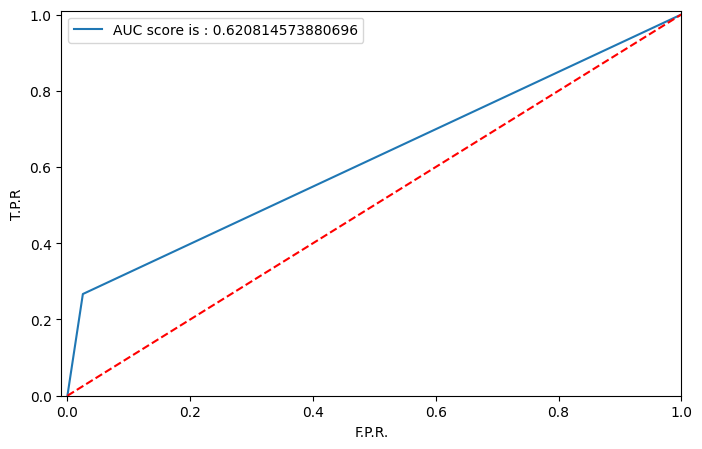

AUC Score for Random Forest is 0.620814573880696


In [71]:
auc_plot(rfc_test_pred, "Random Forest")

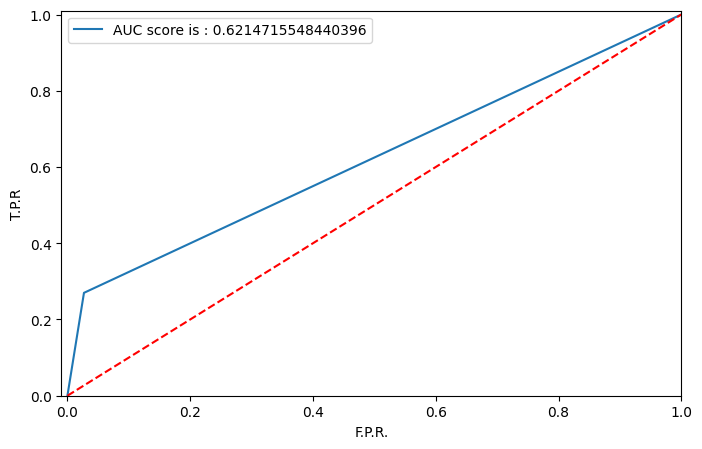

AUC Score for Scaled Random Forest is 0.6214715548440396


In [72]:
auc_plot(rfc_test_pred_scale, "Scaled Random Forest")

Accuracy decreased slightly with scaling for Random Forest Classifier.

### Compare the Models

**AUC Scores**

In [73]:
scores_not_scaled = pd.Series(
    {
        "Dummy": roc_auc_score(y_test, dummy_test_pred),
        "Logistic Regression": roc_auc_score(y_test, logr_test_pred),
        "Decision Tree": roc_auc_score(y_test, dt_test_pred),
        "Random Forest": roc_auc_score(y_test, rfc_test_pred),
    }
)

scores_scaled = pd.Series(
    {
        "Dummy": roc_auc_score(y_test, dummy_test_pred_scale),
        "Logistic Regression": roc_auc_score(y_test, logr_test_pred_scale),
        "Decision Tree": roc_auc_score(y_test, dt_test_pred_scale),
        "Random Forest": roc_auc_score(y_test, rfc_test_pred_scale),
    }
)

scores_df = pd.DataFrame({"Not Scaled": scores_not_scaled, "Scaled": scores_scaled})

Dataframe to compare AUC scores

In [74]:
scores_df

,Not Scaled,Scaled
Dummy,0.500000,0.500000
Logistic Regression,0.588361,0.592189
Decision Tree,0.608702,0.608702
Random Forest,0.620815,0.621472


Highest AUC score is un-scaled Random Forest. Decision Tree is 2nd

In [76]:
accuracy_not_scaled = pd.Series(
    {
        "Dummy": accuracy_score(y_test, dummy_test_pred),
        "Logistic Regression": accuracy_score(y_test, logr_test_pred),
        "Decision Tree": accuracy_score(y_test, dt_test_pred),
        "Random Forest": accuracy_score(y_test, rfc_test_pred),
    }
)

accuracy_scaled = pd.Series(
    {
        "Dummy": accuracy_score(y_test, dummy_test_pred_scale),
        "Logistic Regression": accuracy_score(y_test, logr_test_pred_scale),
        "Decision Tree": accuracy_score(y_test, dt_test_pred_scale),
        "Random Forest": accuracy_score(y_test, rfc_test_pred_scale),
    }
)

accuracy_df = pd.DataFrame(
    {"Not Scaled": accuracy_not_scaled, "Scaled": accuracy_scaled}
)

Dataframe to compare accuracy

In [77]:
accuracy_df

,Not Scaled,Scaled
Dummy,0.882589,0.882589
Logistic Regression,0.895338,0.894973
Decision Tree,0.898009,0.898009
Random Forest,0.891695,0.890481


The highest accuracy of predicting whether a client subsribes to a term deposit or not comes from using a **Decision Tree** Classifer regardless of scaling pre-processing. There may be a bias since the dataset is imbalanaced.

**89.8%**

Below is a snippet of a sampling method to possibly improve imbalance.

Try random sampling method because of the imbalance.

Attempt to minimize the bias

In [78]:
shuffled_df = bank_df.sample(frac=1,random_state=1)
# sample of 5000 from 'no' values
no_df = shuffled_df.loc[shuffled_df['y_num'] == 0].sample(n=5000,random_state=1)
bank_df = pd.concat([yes_df, no_df])